In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import reuters
from nltk import bigrams, trigrams
from collections import Counter, defaultdict
from spacy import displacy

In [2]:
data = pd.read_csv('CleanedDisasterTweets.csv')
target = pd.read_csv('TargetDisasterTweets.csv')

In [3]:
tweets = data[['Text']].values.ravel()
target = target[['target']]
data['target'] = target['target']
data = data[['ID', 'Keyword', 'Text', 'target']]
data.head()

,ID,Keyword,Text,target
0,1,none,our deeds reason earthquake may allah forgive us,1
1,4,none,forest fire near la ronge sask canada,1
2,5,none,all residents asked shelter place notified off...,1
3,6,none,people receive wildfires evacuation orders ca...,1
4,7,none,just got sent photo ruby alaska smoke wildfire...,1


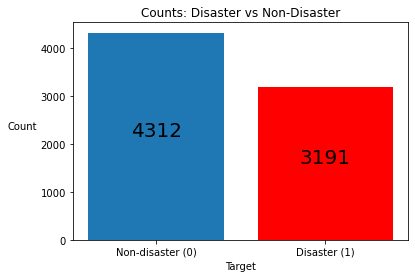

In [4]:
fig, ax = plt.subplots()
ax.bar('0', target.value_counts()[0])
ax.bar('1', target.value_counts()[1], color = 'r')
ax.set_xticks(['0','1'])
ax.set_xticklabels(['Non-disaster (0)', 'Disaster (1)'])
ax.set_xlabel('Target')
h = ax.set_ylabel('Count')
h.set_rotation(0)
h.set_horizontalalignment('right')
t0 = plt.text(-.15,target.value_counts()[0]/2, str(target.value_counts()[0]))
t1 = plt.text(.85,target.value_counts()[1]/2, str(target.value_counts()[1]))
t0.set_fontsize(20)
t1.set_fontsize(20)
plt.title('Counts: Disaster vs Non-Disaster')
plt.show()

We have a relatively even amount of each type of tweet. 

Lets look at the most common Keywords and compare against the targets

In [5]:
key_target = data[['Keyword', 'target']]
key_disaster = key_target[key_target['target'] ==1]
v = key_disaster.value_counts()
v

Keyword    target
none       1         42
outbreak   1         38
debris     1         37
oil spill  1         37
wreckage   1         37
                     ..
blazing    1          1
body bag   1          1
epicentre  1          1
body bags  1          1
ruin       1          1
Length: 221, dtype: int64

Theres only 42 'none' rows but its the most common value in keyword. Lets update those 'none' rows

In [6]:
none_text = list(data[(data['target']==1) & (data['Keyword']=='none')]['Text'].values)

In [7]:
key_words = list(data['Keyword'].unique())

In [8]:
keyword = []
index = 0
for text in none_text:
    words = text.split()
    for word in words:
        if word in key_words:
            print(str(index), 'text index:', none_text.index(text), '; Word:', word)
            index += 1
            keyword.append(word)

0 text index: 0 ; Word: earthquake
1 text index: 1 ; Word: fire
2 text index: 2 ; Word: evacuation
3 text index: 3 ; Word: evacuation
4 text index: 4 ; Word: smoke
5 text index: 5 ; Word: fire
6 text index: 6 ; Word: flood
7 text index: 6 ; Word: disaster
8 text index: 6 ; Word: flooding
9 text index: 7 ; Word: fire
10 text index: 8 ; Word: emergency
11 text index: 8 ; Word: evacuation
12 text index: 9 ; Word: tornado
13 text index: 11 ; Word: flooding
14 text index: 12 ; Word: flooding
15 text index: 13 ; Word: flood
16 text index: 14 ; Word: damage
17 text index: 14 ; Word: crash
18 text index: 15 ; Word: bomb
19 text index: 15 ; Word: army
20 text index: 16 ; Word: police
21 text index: 16 ; Word: flood
22 text index: 17 ; Word: seismic
23 text index: 18 ; Word: attack
24 text index: 19 ; Word: earthquake
25 text index: 20 ; Word: typhoon
26 text index: 20 ; Word: cyclone
27 text index: 23 ; Word: exploded
28 text index: 23 ; Word: screams
29 text index: 24 ; Word: flood
30 text ind

In [9]:
key_dis_counts = data[data['target']==1]['Keyword'].value_counts()

Go through sentences with multiple keywords and choose the keyword with the highest count to replace the 'none' cells

In [10]:
# text 6
key_dis_counts['flood'], key_dis_counts['disaster'], key_dis_counts['flooding']
# keep 'flooding', del index 6, 7

(15, 14, 25)

In [11]:
# text 8
key_dis_counts['emergency'], key_dis_counts['evacuation']
# keep 'evacuation', del index 10

(14, 27)

In [12]:
# text 14
key_dis_counts['damage'], key_dis_counts['crash']
# keep 'damage', del index 17

(19, 12)

In [13]:
# text 15
key_dis_counts['bomb'], key_dis_counts['army']
# keep 'bomb', del index 19

(15, 5)

In [14]:
# text 16
key_dis_counts['police'], key_dis_counts['flood']
# keep 'police', del index 21

(21, 15)

In [15]:
# text 20
key_dis_counts['typhoon'], key_dis_counts['cyclone']
# keep 'typhoon', del index 26 

(37, 19)

In [16]:
# text 23
key_dis_counts['exploded'], key_dis_counts['screams']
# keep 'exploded', del index 28

(9, 5)

In [17]:
# text 25
key_dis_counts['thunderstorm'], key_dis_counts['trauma']
#keep 'thunderstorm', del index 31

(26, 11)

In [18]:
# text 28 earthquake appears twice as is the only keyword
# keep 'earthquake', del index 34

In [19]:
# text 31
key_dis_counts['siren'], key_dis_counts['tornado']
# keep 'tornado', del index 37

(5, 16)

In [20]:
# text 33
key_dis_counts['fire'], key_dis_counts['evacuated']
# keep 'evacuated', del index 40

(11, 31)

In [21]:
# text 34
key_dis_counts['bomb'], key_dis_counts['evacuate']
# keep 'evacuate', del index 42

(15, 25)

In [22]:
# text 40
key_dis_counts['police'], key_dis_counts['collided'], key_dis_counts['injuries']
# theres actually 1 more police from text 17
# keep 'police', del index 48, 49

(21, 21, 9)

In [23]:
# text 41
key_dis_counts['razed'], key_dis_counts['wildfire']
# keep 'razed', del index 51

(31, 29)

In [24]:
removed_key = keyword

In [25]:
removed_key[51]

'wildfire'

In [26]:
del_indices = [6,7,10,17,19,21,26,28,31,34,37,40,42,48,49,51]
kept_kwords = [removed_key[i] for i in range(52) if i not in del_indices]

In [27]:
len(kept_kwords) + len(del_indices)

52

Now look at texts that didn't contain an already used keyword and pick keyword by hand (I've come this far so might as well take it all the way) :p <br> The text indices are the ones that didn't appear in the keywords output

In [28]:
# text 10
none_text[10]
#kw = 'died'

'three people died heat wave far'

In [29]:
kept_kwords.insert(10, 'died')

In [30]:
# text 21
none_text[21]
# kw = 'heat'

'heat wave warning aa ayyo dei just i plan visit friends year'

In [31]:
kept_kwords.insert(21, 'heat wave')

In [32]:
# text 22
none_text[22]
# kw = 'bomber'

'an is group suicide bomber detonated explosivespacked vest mosque inside saudi special forces headquarters killing  people'

In [33]:
kept_kwords.insert(22, 'suicide bomber')

In [34]:
# text 30 
none_text[30]
# kw = 'spill'

'breaking la refugio oil spill may costlier bigger projected httptcouecmcvpk'

In [35]:
kept_kwords.insert(30, 'oil spill')

In [36]:
# text 35
none_text[35]
# kw = 'bomber'

'suicide bomber kills  saudi security site mosque reuters via world google news wall httptconficuloje'

In [37]:
kept_kwords.insert(35, 'suicide bomber')

In [38]:
# text 38
none_text[38]
# kw = 'fires'

'ariaahrary thetawniest the control wild fires california even northern part state very troubling'

In [39]:
kept_kwords.insert(38, 'wild fires')

In [40]:
len(kept_kwords)

42

In [41]:
rep = data

In [42]:
none_indices = list(rep[(rep['target']==1) & (rep['Keyword'] == 'none')].index)
len(none_indices)

42

In [43]:
z = {none_indices[i]:kept_kwords[i] for i in range(len(none_indices))}
z

{0: 'earthquake',
 1: 'fire',
 2: 'evacuation',
 3: 'evacuation',
 4: 'smoke',
 5: 'fire',
 6: 'flooding',
 7: 'fire',
 8: 'evacuation',
 9: 'tornado',
 10: 'died',
 11: 'flooding',
 12: 'flooding',
 13: 'flood',
 14: 'damage',
 7473: 'bomb',
 7475: 'police',
 7476: 'seismic',
 7478: 'attack',
 7479: 'earthquake',
 7480: 'typhoon',
 7481: 'heat wave',
 7482: 'suicide bomber',
 7484: 'exploded',
 7485: 'flood',
 7486: 'thunderstorm',
 7487: 'debris',
 7488: 'collided',
 7489: 'earthquake',
 7490: 'evacuation',
 7491: 'oil spill',
 7492: 'tornado',
 7493: 'quarantine',
 7494: 'evacuated',
 7495: 'evacuate',
 7496: 'suicide bomber',
 7497: 'tornado',
 7498: 'collapse',
 7499: 'wild fires',
 7500: 'volcano',
 7501: 'police',
 7502: 'razed'}

In [44]:
for i, word in z.items(): 
    rep.iloc[i, rep.columns.get_loc('Keyword')] = word

In [45]:
rep

,ID,Keyword,Text,target
0,1,earthquake,our deeds reason earthquake may allah forgive us,1
1,4,fire,forest fire near la ronge sask canada,1
2,5,evacuation,all residents asked shelter place notified off...,1
3,6,evacuation,people receive wildfires evacuation orders ca...,1
4,7,smoke,just got sent photo ruby alaska smoke wildfire...,1
...,...,...,...,...
7498,10869,collapse,two giant cranes holding bridge collapse nearb...,1
7499,10870,wild fires,ariaahrary thetawniest the control wild fires ...,1
7500,10871,volcano,m utckm s volcano hawaii httptcozdtoydebj,1
7501,10872,police,police investigating ebike collided car little...,1


Whew! Now lets look at our top keywords again

In [46]:
key_target = rep[['Keyword', 'target']]
key_disaster = key_target[key_target['target'] ==1]
v = key_disaster.value_counts()
v

Keyword      target
typhoon      1         38
oil spill    1         38
outbreak     1         38
debris       1         38
wreckage     1         37
                       ..
blazing      1          1
electrocute  1          1
epicentre    1          1
body bags    1          1
body bag     1          1
Length: 221, dtype: int64

In [47]:
keycounts = {}
for i in range(10):
    keycounts[v.index[i][0]] = v[i]

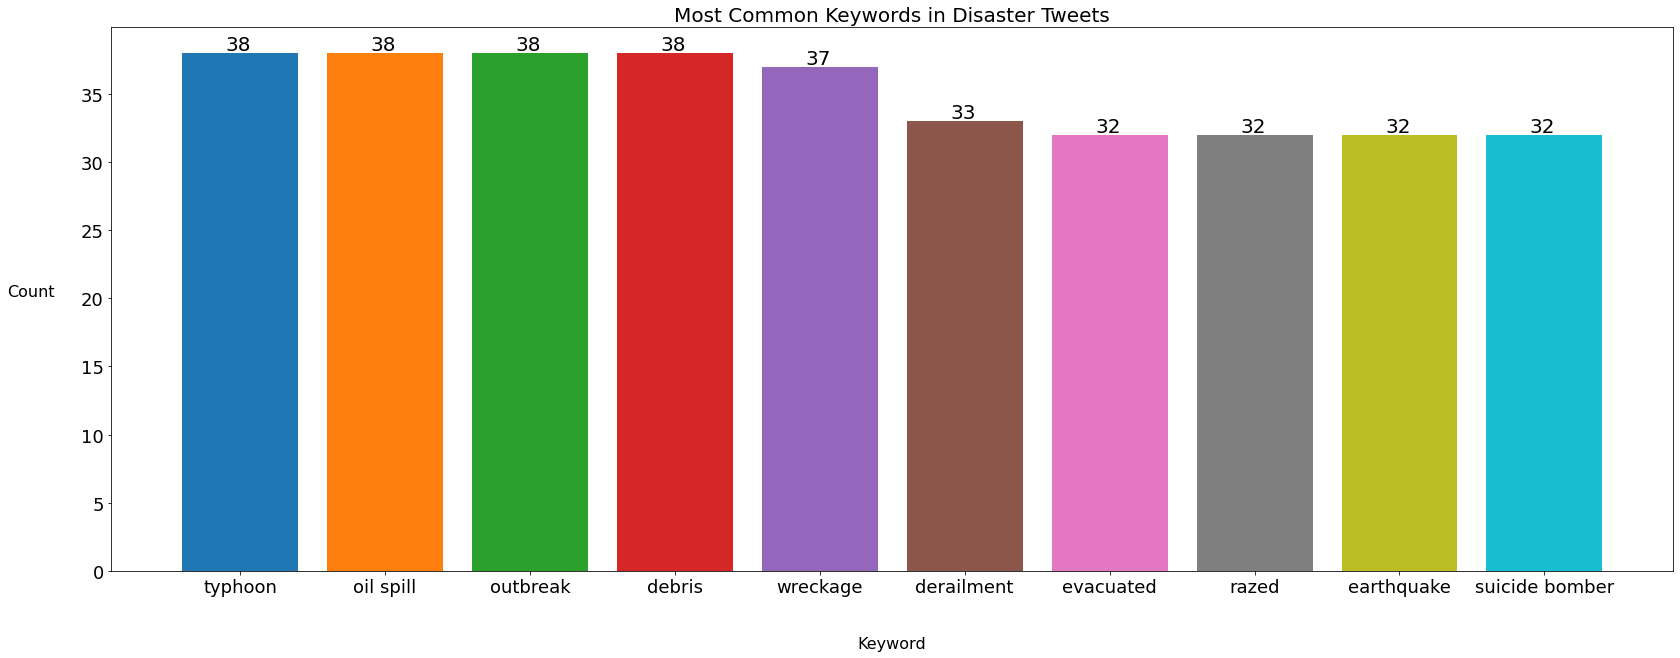

In [48]:
plt.figure(figsize = (28,10))
ax = plt.bar(keycounts.keys(), keycounts.values(), color = mcolors.TABLEAU_COLORS)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
g = plt.xlabel('Keyword', fontsize = 16, labelpad = 40)
h = plt.ylabel('Count', fontsize = 16, labelpad = 50)
h.set_rotation(0)
plt.title('Most Common Keywords in Disaster Tweets', fontsize = 20)
for p in ax.patches:
    plt.text(p.get_x() + .3, p.get_height() +.2, str(p.get_height()), fontsize = 20)
plt.show()

We can see that a few of the missing keywords were in the top 10 most common

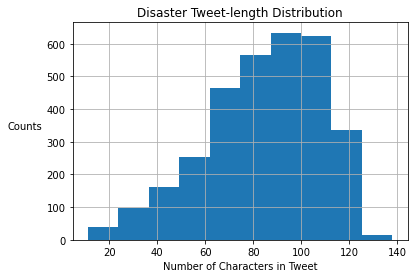

In [66]:
data[data['target']==1]['Text'].str.len().hist()
plt.xlabel('Number of Characters in Tweet')
h = plt.ylabel('Counts', labelpad = 22)
h.set_rotation(0)
plt.title('Disaster Tweet-length Distribution')
plt.show()

In [50]:
data[data['target']==1]['Text'].str.len().describe()

count    3191.000000
mean       84.447822
std        23.850258
min        11.000000
25%        69.000000
50%        88.000000
75%       103.000000
max       138.000000
Name: Text, dtype: float64

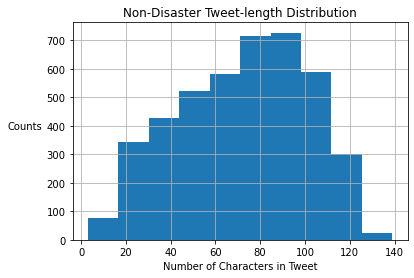

In [67]:
data[data['target']==0]['Text'].str.len().hist()
plt.xlabel('Number of Characters in Tweet')
h = plt.ylabel('Counts', labelpad = 22)
h.set_rotation(0)
plt.title('Non-Disaster Tweet-length Distribution')
plt.show()

In [52]:
data[data['target']==0]['Text'].str.len().describe()

count    4312.000000
mean       72.199212
std        28.608500
min         3.000000
25%        50.000000
50%        75.000000
75%        96.000000
max       139.000000
Name: Text, dtype: float64

We can see that Disaster tweets are, on average, 12 characters longer than Non-Disaster tweets. This makes sense considering disasters would warrant atleast a detailed description.

In [53]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

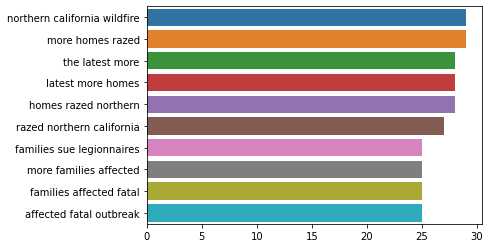

In [54]:
top_tri_grams=get_top_ngram(data[data['target']==1]['Text'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)
plt.show()

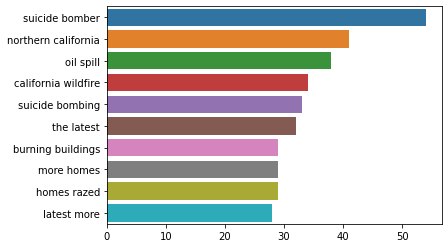

In [55]:
top_n_bigrams=get_top_ngram(data[data['target']==1]['Text'],2)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x)
plt.show()

In [56]:
# nlp = spacy.load("en_core_web_sm")
# doc = nlp(data['Text'][0])

# displacy.render(data['Text'][0], style='ent')

In [57]:
# cv = CountVectorizer(analyzer='word', max_features=2700, strip_accents = 'ascii')
# X = cv.fit_transform(tweets)
# X_col = vector.get_feature_names_out()
# df = pd.DataFrame.sparse.from_spmatrix(X, columns = X_col)
# df.head()
cv=CountVectorizer(analyzer='word', strip_accents = 'ascii')
vector=cv.fit_transform(data['Text'])
df_dtm = pd.DataFrame(vector.toarray(), columns=cv.get_feature_names_out())
df_dtm.index=data.index
df_dtm = df_dtm[:3]
df_dtm.index = ['one', 'two', 'three']
df_dtm

,aa,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aaceorg,aaemiddleaged,aal,aampb,aampw,...,zoom,zotar,zouma,zourryart,zrnf,zss,zumiez,zurich,zxathetis,zzzz
one,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
two,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
three,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


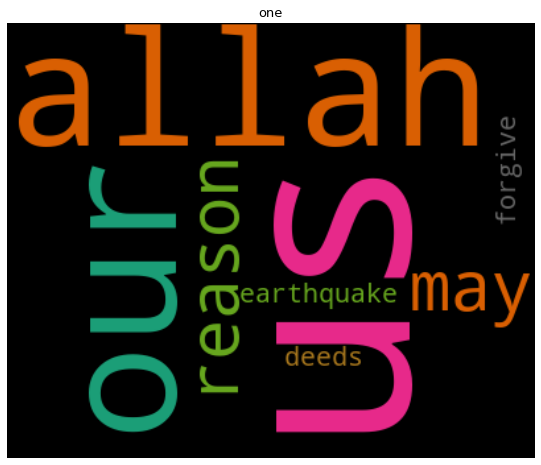

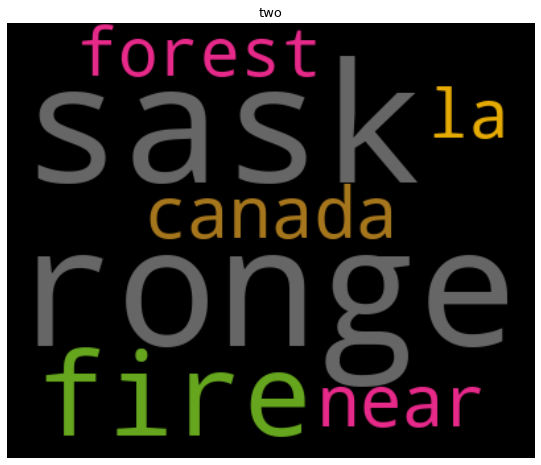

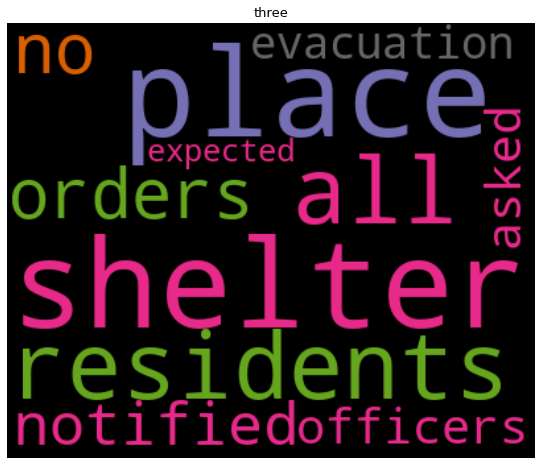

In [58]:
from wordcloud import WordCloud
from textwrap import wrap

# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()
  
# Transposing document term matrix
df_dtm=df_dtm.transpose()

# Plotting word cloud for each product
for index,product in enumerate(df_dtm.columns):
  generate_wordcloud(df_dtm[product].sort_values(ascending=False),product)